In [1]:
# Load modules
import sys
sys.path.append('../utilities_tlezuo/')

import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
from wrf import getvar, interp1d
from netCDF4 import Dataset

from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import datetime as dt

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## CONSTANT FILE  ##
c_filename = "lfff00000000c.nc"
filepath = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'
const_file = filepath + c_filename
data_c = psy.open_dataset(const_file)

###############################################################################################
## DECIDE ##
# where to save
loadpath = '/users/tlezuo/icon-vis/height_time_diagrams/data/'
# decide which locations to calculate
loc_list = []
# loc_list.extend([])
loc_list=[lf.kols]

# decide which variables to calculate
pvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.U, vf.V, vf.T,vf.TH,vf.QV,vf.P,vf.VEL,vf.DIR]

###############################################################################################
## DATELISTS ##
# ICON model: as writeout times: 30 min
startdate_model = dt.datetime(2019,9,12,12,00)
enddate_model = dt.datetime(2019,9,14,00,00)
plotdates_model = pd.date_range(startdate_model,enddate_model,freq='0h30min')
# radiosoundings: 3h and 2h intervals
plotdates_rs = [dt.datetime(2019,9,12,23,00),dt.datetime(2019,9,13,3,00),dt.datetime(2019,9,13,6,00),dt.datetime(2019,9,13,9,00),
dt.datetime(2019,9,13,11,00),dt.datetime(2019,9,13,13,00),dt.datetime(2019,9,13,15,00),dt.datetime(2019,9,13,17,00),dt.datetime(2019,9,13,20,00),dt.datetime(2019,9,13,23,00)]
# radiosoundings Munich: 00+12
plotdates_murs = [dt.datetime(2019,9,12,12,00),dt.datetime(2019,9,13,0,00),dt.datetime(2019,9,13,12,00),dt.datetime(2019,9,14,0,00)]
# lidar SR88: 10 min
plotdates_lidar = pd.date_range(startdate_model,enddate_model,freq='0h10min')

In [3]:
## LOAD DATA ##
# ICON model
htd_data_model = {}
htd_data_model['kols'] = np.load(loadpath+'htd_ICON_kols.npy',allow_pickle='TRUE').item()
htd_data_model['murs'] = np.load(loadpath+'htd_ICON_murs.npy',allow_pickle='TRUE').item()
htd_data_model['ifl'] = np.load(loadpath+'htd_ICON_ifl.npy',allow_pickle='TRUE').item()

# Streamline Lidar SR88
htd_data_lidar_SL88 = xr.open_dataset(loadpath+'htd_lidar_SL88_Kolsass.nc').load()
htd_data_lidar_SL88 = htd_data_lidar_SL88.transpose()
# Streamline Lidar SLXR142
htd_data_lidar_SLXR142 = xr.open_dataset(loadpath+'htd_lidar_SLXR142_Kolsass.nc').load()
# HATPRO Lidar
htd_data_lidar_hatpro = xr.open_dataset(loadpath+'htd_lidar_hatpro_Kolsass.nc').load()
htd_data_lidar_hatpro = htd_data_lidar_hatpro.transpose()

# Kolsass radiosoundings
htd_data_kolsrs = np.load(loadpath+'htd_rs_Kolsass.npy',allow_pickle='TRUE').item()
htd_data_kolsrs_interp = np.load(loadpath+'htd_rs_interp_Kolsass.npy',allow_pickle='TRUE').item()
# Munich radiosounding
htd_data_murs = np.load(loadpath+'htd_rs_Munich.npy',allow_pickle='TRUE').item()
htd_data_murs_interp = np.load(loadpath+'htd_rs_interp_Munich.npy',allow_pickle='TRUE').item()
# Innsbruck radiosounding
htd_data_iflrs = np.load(loadpath+'htd_rs_Innsbruck.npy',allow_pickle='TRUE').item()
htd_data_iflrs_interp = np.load(loadpath+'htd_rs_interp_Innsbruck.npy',allow_pickle='TRUE').item()

In [4]:
def get_sounding(pvar,pdate,loc):
    # model levels
    lev_model = htd_data_model[loc.short]['HFL_loc']
    lev_model_cut = lev_model[0:73]

    # indices for model
    plotdates_model_list = list(plotdates_model)
    ti_model = plotdates_model_list.index(pdate)

    # get data model
    sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
    sounding_model_cut = sounding_model[0:73]       

    if pdate.strftime('%H') == '02': # if 02 -> we want to see ifl sounding
        # index for rs Innsbruck is always 0
        ti_rs = 0
        sounding_rs_interp = np.array(htd_data_iflrs_interp[pvar.name][ti_rs,:])
    
    elif pdate.strftime('%H') == '12' or pdate.strftime('%H') ==  '00': # if 12 or 00 -> we want to see murs sounding
        # index for rs Munich
        ti_rs = plotdates_murs.index(pdate)
        sounding_rs_interp = np.array(htd_data_murs_interp[pvar.name][ti_rs,:])
    
    else: # else -> we want Kolsass/CROSSINN sounding
        # index for rs Kolsass
        ti_rs = plotdates_rs.index(pdate)
        sounding_rs_interp = np.array(htd_data_kolsrs_interp[pvar.name][ti_rs,:])

    return lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs

def plot_sounding(pvar, pdate, loc, axis):

    lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs = get_sounding(pvar,pdate,loc)                                                                                          
    # plot it
    m = axis.plot(sounding_model_cut,  lev_model_cut, lw=2,color='dodgerblue',label='ICON')
    r = axis.plot(sounding_rs_interp,  lev_model_cut, lw=2,color='darkviolet',label='observations')
    
    # fill between to highlight bias
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut > sounding_rs_interp), alpha=0.2, color='orangered')
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut < sounding_rs_interp), alpha=0.2, color='cyan')

    # title
    axis.set_title(pdate.strftime('%H:%M'), fontsize=12)
    
    # windbarbs
    if pvar.name == 'VEL':
        q_scale = 30
        q_width = 0.002
        lev_model_cut,U_model,U_rs,ti_model,ti_rs = get_sounding(vf.U,pdate,loc)
        lev_model_cut,V_model,V_rs,ti_model,ti_rs = get_sounding(vf.V,pdate,loc)
        axis.quiver(np.full(73,20), lev_model_cut, U_model, V_model, 
            scale=q_scale, scale_units='inches', width=q_width,color='dodgerblue')
        axis.quiver(np.full(73,15), lev_model_cut, U_rs,V_rs, 
            scale=q_scale, scale_units='inches', width=q_width,color='darkviolet')


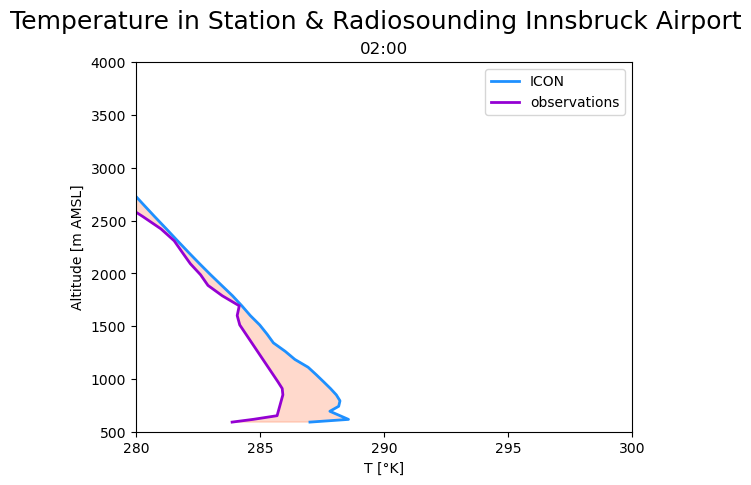

In [5]:
## PLOT SINGLE PROFILE ##
# general settings
pvar = vf.T
loc= lf.ifl
pdate = dt.datetime(2019,9,13,2,00) # only at rs times

# plotsettings
xmin=280
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
plot_sounding(pvar, pdate, loc, ax)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

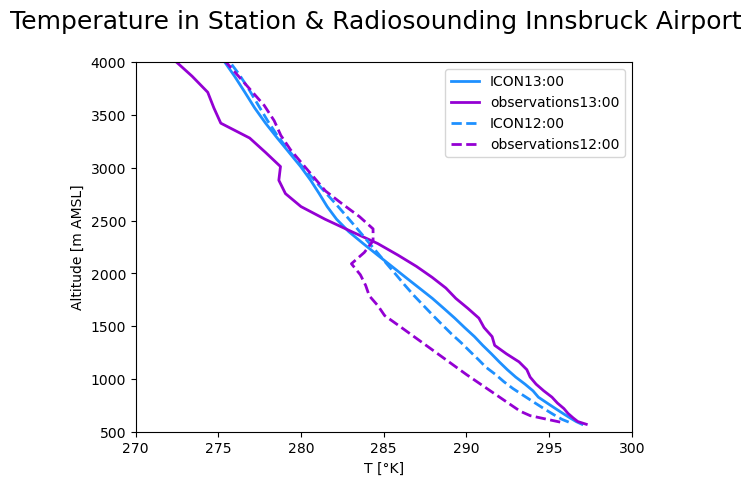

In [6]:
## PLOT MULTIPLE PROFILES in 1 PLOT ##
# general settings
pvar = vf.T
pdate1 = dt.datetime(2019,9,13,13,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,12,00)
loc2= lf.ifl
# pdate3 = dt.datetime(2019,9,13,17,00)
# loc1= lf.kols

# plotsettings
xmin=270
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='observations'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='observations'+pdate2.strftime('%H:%M'))
# # third time
# lev_model_cut,sounding_model_cut3,sounding_rs_interp3,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc3) 
# m3 = ax.plot(sounding_model_cut3,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
# r3 = ax.plot(sounding_rs_interp3,  lev_model_cut, lw=2,color='darkviolet',linestyle='dotted',label='observations'+pdate3.strftime('%H:%M'))
                                                                                                                                                                          
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

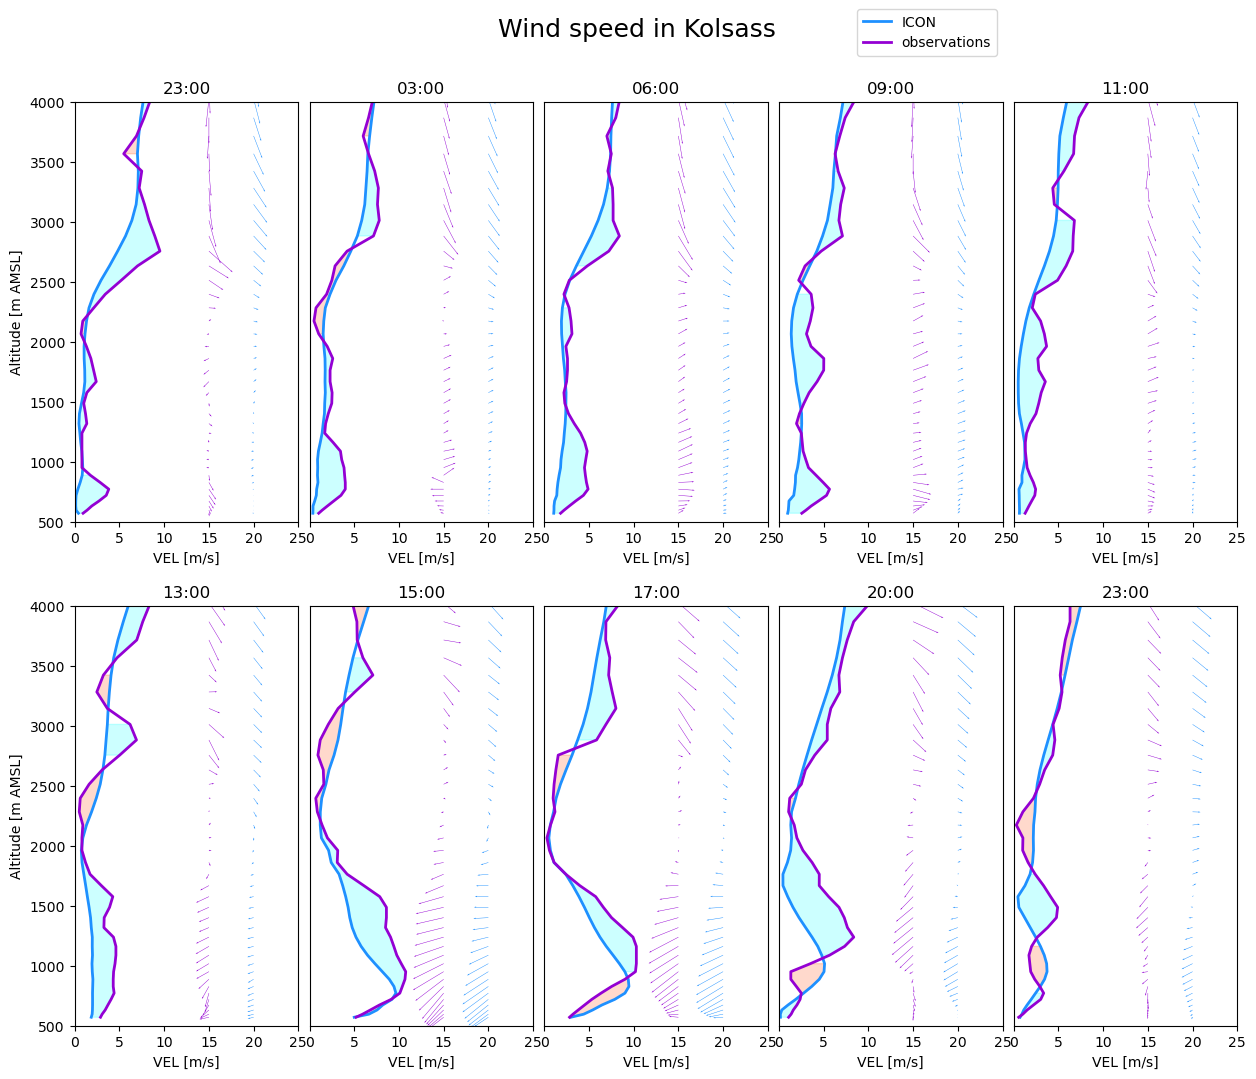

In [7]:
## PLOT ALL PROFILES ##
# settings
pvar = vf.VEL
loc= lf.kols
xmin=0
xmax=25

ymin=500
ymax=4000

# plots
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2,wspace=0.05)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.95)
for index, ax in enumerate(axes.ravel()):
    pdate = plotdates_rs[index]
    plot_sounding(pvar, pdate, loc, ax)
    # x
    xdelticks=5
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel(pvar.name+' '+pvar.units)
    # ax.set_xticklabels(['',285,290,295,''])
    # y
    ydelticks=500
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel(None)
    ax.set_yticks([])
# set y ticks to left plot
axes[0,0].set_ylabel('Altitude [m AMSL]')
axes[0,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
axes[1,0].set_ylabel('Altitude [m AMSL]')
axes[1,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
plt.legend(loc=(-0.7,2.31))
plt.show()

In [14]:
## COMPUTE THE TENDENCIES BETWEEN RS ##
pvar= vf.T

diffname = pvar.name+'_diff'

plotdates_model_list = list(plotdates_model)
htd_data_model['kols'][diffname] = np.empty((len(plotdates_model_list),73))
htd_data_kolsrs_interp[diffname] = np.empty((10,73))

for now in range(1,10):
    # dates
    pdate_now = plotdates_rs[now]
    pdate_before = plotdates_rs[now-1]
    delt=pdate_now-pdate_before
    # model
    sounding_model_now = np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now),:][0:73])
    sounding_model_before = np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_before),:][0:73])
    htd_data_model['kols'][diffname][plotdates_model_list.index(pdate_now)] = (sounding_model_now-sounding_model_before)/(delt.seconds/3600)
     
    # rs
    sounding_rs_interp_now = np.array(htd_data_kolsrs_interp[pvar.name][now,:])
    sounding_rs_interp_before = np.array(htd_data_kolsrs_interp[pvar.name][now-1,:])
    htd_data_kolsrs_interp[diffname][now] = (sounding_rs_interp_now - sounding_rs_interp_before)#/(delt.seconds/3600)

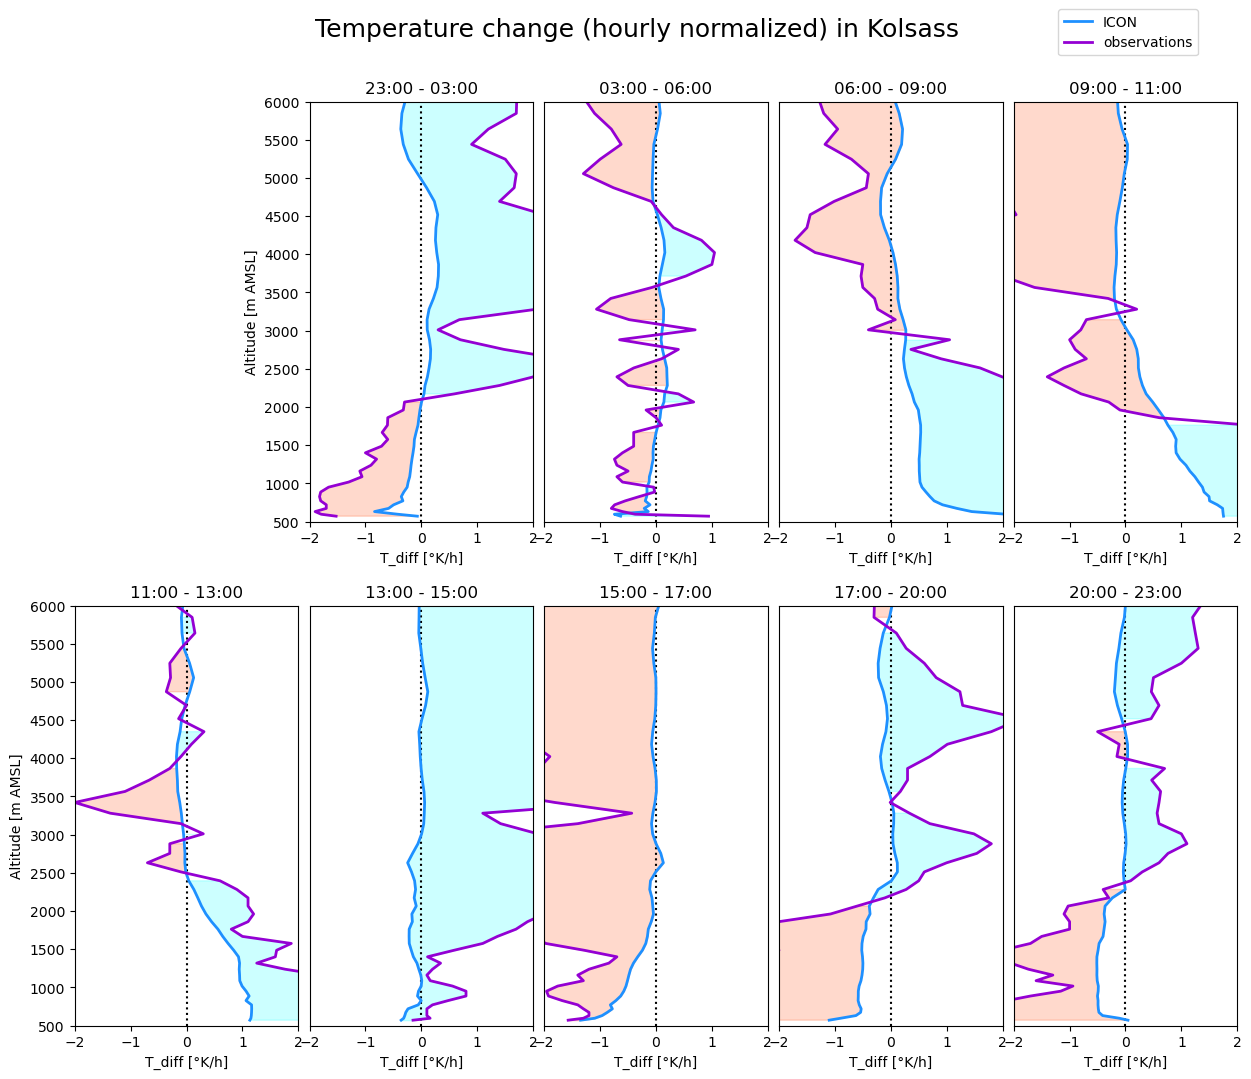

In [15]:
## PLOT ALL PROFILES ##
# settings
pvar = vf.T_diff
xmin=-2
xmax=2

ymin=500
ymax=6000

# plots
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2,wspace=0.05)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.95)
for index, ax in enumerate(axes.ravel()):
    pdate = plotdates_rs[index]
    plot_sounding(pvar, pdate,lf.kols, ax)
    # x
    xdelticks=5
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel(pvar.name+' '+pvar.units)
    # ax.set_xticklabels(['',285,290,295,''])
    # y
    ydelticks=500
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.vlines(0,ymin,ymax,colors='k', linestyles='dotted')
    ax.set_title(plotdates_rs[index-1].strftime('%H:%M')+' - '+pdate.strftime('%H:%M'), fontsize=12)
# set y ticks to left plot
f.delaxes(axes[0,0])
axes[0,1].set_ylabel('Altitude [m AMSL]')
axes[0,1].set_yticks(np.arange(ymin,ymax+1,ydelticks))
axes[1,0].set_ylabel('Altitude [m AMSL]')
axes[1,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
plt.legend(loc=(0.2,2.31))
plt.show()

In [10]:
## TENDENCIES BETWEEN RS IN MODEL ##
# (only for Kolsass as high enough frequency)
for now in range(1,len(plotdates_rs)):
    # dates
    pdate_now = plotdates_rs[now]
    pdate_before = plotdates_rs[now-1]
    delt=pdate_now-pdate_before
    plotdates_model_list = list(plotdates_model)
    print(plotdates_model_list.index(pdate_now))
    
    # compute difference for each variable
    for pvar in pvars_list:
        htd_data_model['kols'][pvar.name+'_diff'] = np.empty((len(plotdates_model_list),73))
        htd_data_model['kols'][pvar.name+'_diff'][plotdates_model_list.index(pdate_now)]  = np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now),:][0:73]) - np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_before),:][0:73])


30
36
42
46
50
54
58
64
70


/tmp/ipykernel_211923/3538021012.py:14: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  htd_data_model['kols'][pvar.name+'_diff'][plotdates_model_list.index(pdate_now)]  = np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now),:][0:73]) - np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_before),:][0:73])


In [11]:
pvar = vf.T
pdate_now=dt.datetime(2019,9,13,13,00)
htd_data_model['kols'][pvar.name+'_diff']
np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now),:][0:73])-np.array(htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_before),:][0:73])

array([ 6.72646258e+00,  5.51617216e+00,  4.39075994e+00,  3.92000420e+00,
        3.62688407e+00,  3.43362830e+00,  3.19214166e+00,  3.14383695e+00,
        2.99687302e+00,  2.77645526e+00,  2.60364740e+00,  2.53153915e+00,
        2.50458225e+00,  2.45745687e+00,  2.45653038e+00,  2.40239496e+00,
        2.34232492e+00,  2.22485592e+00,  2.04022953e+00,  1.80939669e+00,
        1.54027755e+00,  1.44924399e+00,  1.32845381e+00,  1.10947943e+00,
        4.06101194e-01,  4.14184748e-03, -1.24989748e-01, -7.78907249e-02,
       -2.05820851e-03,  2.22094498e-03, -8.22882178e-02, -1.58510157e-01,
       -1.52700959e-01, -1.08984599e-02,  2.59777728e-01,  5.26925172e-01,
        7.00636746e-01,  6.58693368e-01,  4.62748902e-01,  1.95512355e-01,
        8.72537301e-02,  1.65838842e-01,  5.22683496e-01,  7.06361576e-01,
        7.15539018e-01,  5.54529783e-01,  1.74330689e-01, -1.87724528e-01,
       -3.42651403e-01, -2.69211188e-01,  4.69090422e-02,  2.57153251e-01,
        3.33671670e-01,  

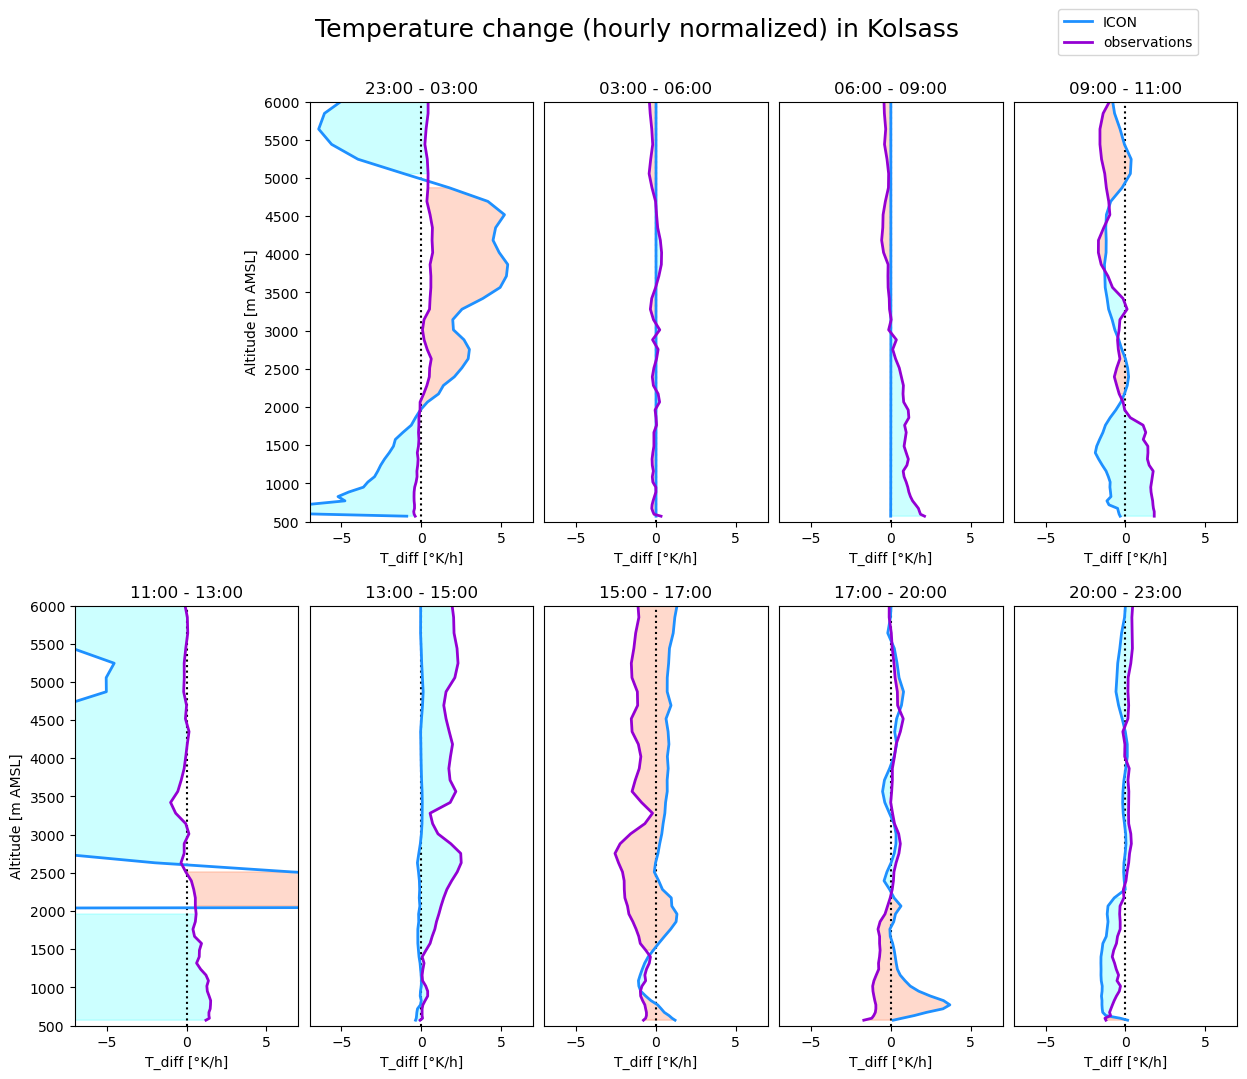

In [12]:

# settings
pvar = vf.T_diff
loc = lf.kols
xmin=-7
xmax=7

ymin=500
ymax=6000

# plots
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2,wspace=0.05)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.95)
for index, ax in enumerate(axes.ravel()):
    pdate = plotdates_rs[index]
    plot_sounding(pvar, pdate,loc, ax)
    # x
    xdelticks=5
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel(pvar.name+' '+pvar.units)
    # ax.set_xticklabels(['',285,290,295,''])
    # y
    ydelticks=500
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.vlines(0,ymin,ymax,colors='k', linestyles='dotted')
    ax.set_title(plotdates_rs[index-1].strftime('%H:%M')+' - '+pdate.strftime('%H:%M'), fontsize=12)
# set y ticks to left plot
f.delaxes(axes[0,0])
axes[0,1].set_ylabel('Altitude [m AMSL]')
axes[0,1].set_yticks(np.arange(ymin,ymax+1,ydelticks))
axes[1,0].set_ylabel('Altitude [m AMSL]')
axes[1,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
plt.legend(loc=(0.2,2.31))
plt.show()

In [13]:
htd_data_model['VEL']

KeyError: 'VEL'